## Import All Dependencies & Libraries

## Data Prepocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer

csv_path = 'https://raw.githubusercontent.com/DyanielCX/DLI-Assm/refs/heads/main/dataset_B_05_2020_1.csv'
df = pd.read_csv(csv_path)

text_col_candidates = [c for c in df.columns if c.lower() in ['url','text','content','message','body','title'] or 'url' in c.lower()]
label_col_candidates = [c for c in df.columns if c.lower() in ['label','status','target','class','category','phishing']]

if not text_col_candidates or not label_col_candidates:
    raise ValueError(f"Could not infer columns. Columns found: {df.columns.tolist()}")

text_col = text_col_candidates[0]
label_col = label_col_candidates[0]

X_text = df[text_col].astype(str).fillna('')
y_raw = df[label_col].astype(str).fillna('')

X_train_text, X_temp_text, y_train_raw, y_temp_raw = train_test_split(X_text, y_raw, test_size=0.3, random_state=42, stratify=y_raw)
X_val_text, X_test_text, y_val_raw, y_test_raw = train_test_split(X_temp_text, y_temp_raw, test_size=0.5, random_state=42, stratify=y_temp_raw)

tokenizer = Tokenizer(lower=True, char_level=True, oov_token='-n-')
tokenizer.fit_on_texts(pd.concat([X_train_text, X_val_text, X_test_text], axis=0))

X_train = tokenizer.texts_to_sequences(list(X_train_text))
X_val = tokenizer.texts_to_sequences(list(X_val_text))
X_test = tokenizer.texts_to_sequences(list(X_test_text))

encoder = LabelEncoder()
encoder.fit(sorted(y_raw.unique()))
y_train = to_categorical(encoder.transform(y_train_raw))
y_val = to_categorical(encoder.transform(y_val_raw))
y_test = to_categorical(encoder.transform(y_test_raw))

epochs = 10
batch_size = 128
sequence_length = 200
embed_dim = 50

print(f'Using text column: {text_col}')
print(f'Using label column: {label_col}')
print('Data ready.')


Using text column: url
Using label column: status
Data ready.


## Model Training



### CNN-only version
This notebook uses a character-level CNN (`cnn_base`) for phishing URL/text detection. It keeps preprocessing, CNN model, training, evaluation, and plots.


In [2]:
# CNN model definition (improved CNN, same signature as before)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D

def build_cnn_base(vocab_size, embed_dim=50, sequence_length=200, num_classes=2):
    """Improved CNN while preserving the original API.
    Embedding -> [Conv+Pool]*2 -> Conv -> GlobalMaxPool -> Dense -> Output.
    Keeps defaults (embed_dim=50, sequence_length=200) so other cells remain unchanged.
    """
    model = Sequential()
    model.add(Embedding(vocab_size + 1, embed_dim, input_length=sequence_length))

    # Block 1
    model.add(Conv1D(128, 5, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # Block 2
    model.add(Conv1D(128, 5, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # Feature consolidation
    model.add(Conv1D(256, 3, activation='relu', padding='same'))
    model.add(GlobalMaxPooling1D())

    # Classifier head
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))
    return model


In [3]:

# Compile and train CNN
from keras.preprocessing import sequence
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import time

sequence_length = 200 if 'sequence_length' not in globals() else sequence_length
x_train_pad = sequence.pad_sequences(X_train, maxlen=sequence_length)
x_val_pad = sequence.pad_sequences(X_val, maxlen=sequence_length)
x_test_pad = sequence.pad_sequences(X_test, maxlen=sequence_length)

vocab_size = len(tokenizer.word_index)
num_classes = y_train.shape[1]
embed_dim = 50 if 'embed_dim' not in globals() else embed_dim

cnn_model = build_cnn_base(vocab_size=vocab_size, embed_dim=embed_dim, sequence_length=sequence_length, num_classes=num_classes)
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

start_time = time.time()
history = cnn_model.fit(
    x_train_pad, y_train,
    validation_data=(x_val_pad, y_val),
    epochs=epochs if 'epochs' in globals() else 10,
    batch_size=batch_size if 'batch_size' in globals() else 128,
    shuffle=True,
    verbose=1
)
train_time = time.time() - start_time

test_loss, test_acc = cnn_model.evaluate(x_test_pad, y_test, verbose=0)

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(cnn_model.predict(x_test_pad, verbose=0), axis=1)
report = classification_report(y_true, y_pred, digits=4)
cm = confusion_matrix(y_true, y_pred)

print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(report)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.6332 - loss: 0.6087 - val_accuracy: 0.8221 - val_loss: 0.4072
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.7991 - loss: 0.4135 - val_accuracy: 0.8331 - val_loss: 0.3688
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.8405 - loss: 0.3574 - val_accuracy: 0.8495 - val_loss: 0.3488
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.8576 - loss: 0.3270 - val_accuracy: 0.8524 - val_loss: 0.3477
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.8618 - loss: 0.3101 - val_accuracy: 0.8448 - val_loss: 0.3600
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.8712 - loss: 0.3048 - val_accuracy: 0.8483 - val_loss: 0.3415
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.8771 - loss: 0.2826 - val_accuracy: 0.8466 - val_loss: 0.3461
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.8844 - loss: 0.2693 - val_accuracy: 0.8442 - va

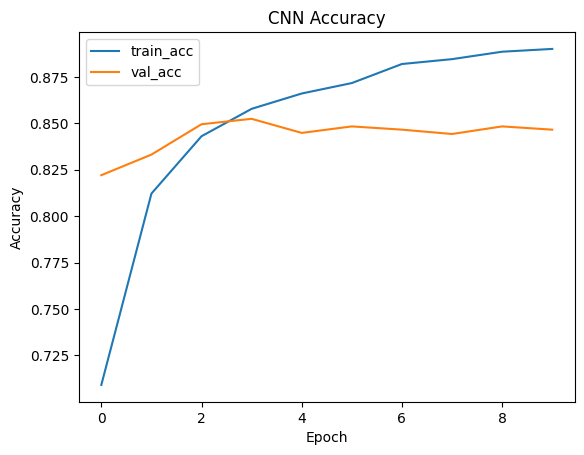

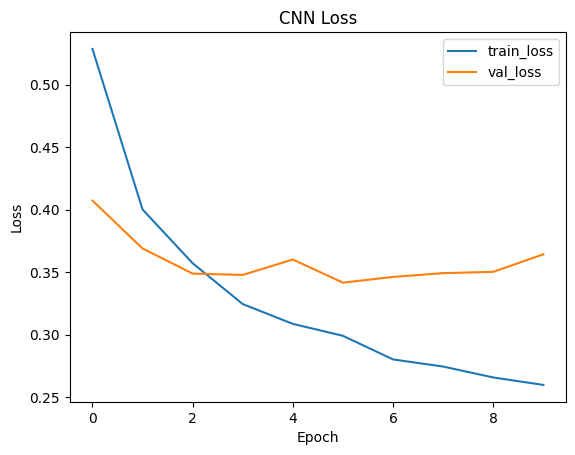

In [4]:

# Plot training curves for CNN
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN Accuracy')
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN Loss')
plt.show()
